# Modelo usando Aumento de Datos

### Arquitectura del modelo

La arquitectura utilizada en este trabajo se basa en el modelo U-Net, ilustrado en la Figura 1, el cual consta de una ruta de contracción (lado izquierdo) y una ruta de expansión (lado derecho). En su formulación original, la U-Net emplea bloques convolucionales compuestos por convoluciones de 3×3 seguidas de funciones de activación ReLU y operaciones de max pooling para el submuestreo, duplicando progresivamente el número de canales de características. La ruta de expansión reconstruye la resolución espacial mediante operaciones de upsampling y convoluciones, combinando la información proveniente de la ruta de contracción a través de conexiones de salto (skip connections). Finalmente, una convolución de 1×1 permite proyectar el mapa de características al número deseado de clases [1].
Sobre esta arquitectura base, se implementó una versión adaptada para la segmentación de aneurismas intracraneales. En particular, el codificador de la U-Net original fue reemplazado por una red ResNet34 preentrenada en el conjunto de datos ImageNet, lo que permitió aprovechar características visuales previamente aprendidas y mejorar la eficiencia del entrenamiento.

Adicionalmente, se incorporó un mecanismo de atención del tipo scSE (spatial and channel Squeeze-and-Excitation) en el decodificador, el cual permite recalibrar de manera adaptativa las características espaciales y de canal, favoreciendo el enfoque del modelo en regiones relevantes de la imagen, como las zonas cercanas a los aneurismas.

Finalmente, una capa convolucional de 1×1 se utilizó para proyectar el mapa de características final a una única clase de salida, correspondiente a la segmentación binaria de aneurismas.
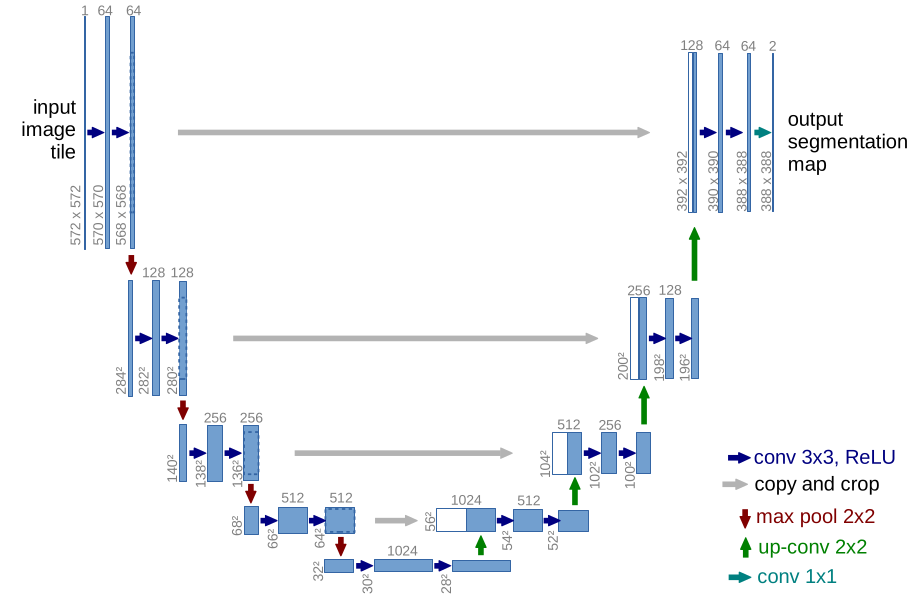

Figura 1. Arquitectura U-Net. Tomada de [1].

### Función de costo 

La función de costo utilizada en este trabajo es la \textit{Tversky Loss}, una generalización del coeficiente Dice diseñada para problemas de segmentación con clases altamente desbalanceadas. Su formulación matemática se define como una razón entre la intersección de la predicción y la referencia, y una combinación ponderada de verdaderos positivos, falsos positivos y falsos negativos. En esta expresión, $p_{0i}$ representa la probabilidad predicha de que el vóxel $i$ pertenezca a la clase aneurisma, mientras que $p_{1i}$ corresponde a la probabilidad de la clase no aneurisma. De forma análoga, $g_{0i}$ y $g_{1i}$ indican las etiquetas reales del vóxel $i$ [2].

Los parámetros $\alpha$ y $\beta$ controlan la penalización asociada a los falsos positivos y falsos negativos, respectivamente. Esto permite ajustar el compromiso entre precisión y sensibilidad según las necesidades del problema. En particular, valores altos de $\beta$ incrementan la penalización de los falsos negativos, favoreciendo una mayor sensibilidad del modelo [2]. 

$$T(\alpha, \beta) =
\frac{\sum_{i=1}^{N} p_{0i} g_{0i}}
{\sum_{i=1}^{N} p_{0i} g_{0i}
+ \alpha \sum_{i=1}^{N} p_{0i} g_{1i}
+ \beta \sum_{i=1}^{N} p_{1i} g_{0i}}$$

Durante el entrenamiento se utilizó un valor alto del parámetro $\beta$
$(\beta=0.9)$, con el fin de favorecer la detección de aneurismas y reducir al máximo los casos en los que el modelo no los identifica. Esta configuración permite penalizar con mayor peso los falsos negativos.

In [1]:
# Se importan las librerías necesarias para el procesamiento de datos, manejo de tensores y construcción del modelo.
# pandas y numpy para manipulación de datos.
# sklearn para dividir el dataset.
# torch y sus submódulos para crear y entrenar la red neuronal.
# cv2 para procesamiento de imágenes.
# matplotlib para visualización.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
# Se carga el dataset completo que contiene la información de las imágenes procesadas.
df_completo=pd.read_csv('dataset_dataaugmentation.csv')
df_completo

,SeriesInstanceUID,SOPInstanceUID,npy_path,x,y,label
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.66911171872877028453...,1.2.826.0.1.3680043.8.498.66911171872877028453...,-1.000000,-1.000000,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,1.2.826.0.1.3680043.8.498.10587118170829166010...,1.2.826.0.1.3680043.8.498.10587118170829166010...,-1.000000,-1.000000,0
2,1.2.826.0.1.3680043.8.498.10014757658335054766...,1.2.826.0.1.3680043.8.498.76601744454891248086...,1.2.826.0.1.3680043.8.498.76601744454891248086...,-1.000000,-1.000000,0
3,1.2.826.0.1.3680043.8.498.10021411248005513321...,1.2.826.0.1.3680043.8.498.81593405716626656866...,1.2.826.0.1.3680043.8.498.81593405716626656866...,-1.000000,-1.000000,0
4,1.2.826.0.1.3680043.8.498.10040419508532196461...,1.2.826.0.1.3680043.8.498.11401266297286362999...,1.2.826.0.1.3680043.8.498.11401266297286362999...,-1.000000,-1.000000,0
...,...,...,...,...,...,...
4115,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.10885430363476327277...,1.2.826.0.1.3680043.8.498.10885430363476327277...,306.767517,294.566711,1
4116,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.75978746530527925899...,1.2.826.0.1.3680043.8.498.75978746530527925899...,161.547775,323.896423,1
4117,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.88559536225248716051...,1.2.826.0.1.3680043.8.498.88559536225248716051...,348.306488,215.030411,1
4118,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.41770479778255354615...,1.2.826.0.1.3680043.8.498.41770479778255354615...,312.250732,210.714905,1


In [3]:
import numpy as np
import os

# Se define la ruta base donde se encuentran los archivos .npy.
base_dir = '/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_procesados_npy/'

indices_validos = []

# Se itera sobre cada registro del dataset para verificar la integridad de los archivos.
for i in range(len(df_completo)):
    filename = df_completo['npy_path'][i]
    path = os.path.join(base_dir, filename)

    try:
        # Se comprueba si el archivo existe físicamente en el disco.
        if os.path.exists(path):
            img = np.load(path)
            # Se valida que las dimensiones de la imagen sean exactamente 512x512x3.
            if img.shape == (512, 512, 3):
                indices_validos.append(i)
            else:
                # Si las dimensiones son incorrectas, se elimina el archivo para evitar errores futuros.
                print(f"Eliminando {filename} por dimensiones incorrectas: {img.shape}")
                os.remove(path)
        else:
            print(f"Archivo no encontrado: {filename}")
    except Exception as e:
        print(f"Error procesando {filename}: {e}")

# Se filtra el DataFrame original conservando solo los registros con archivos válidos.
df_filtrado = df_completo.iloc[indices_validos].reset_index(drop=True)



Archivo no encontrado: 1.2.826.0.1.3680043.8.498.12524552726742591936607820382077304797.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.37968147245973562230977823049232474212.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.12112808457186454422752724768665392380.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.97121094041712829608625148100059963709.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.97121094041712829608625148100059963709.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.19224467190200667623464386249242006134.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.73981904975387593351832419181112323522.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.75624390816274267057679985409783222714.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.17068119801903677540294516696338424399.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.11678059097199251350380591511662657565.npy
Archivo no encontrado: 1.2.826.0.1.3680043.8.498.1021670885207474523744593065219

In [4]:
df_filtrado

,SeriesInstanceUID,SOPInstanceUID,npy_path,x,y,label
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,1.2.826.0.1.3680043.8.498.66911171872877028453...,1.2.826.0.1.3680043.8.498.66911171872877028453...,-1.000000,-1.000000,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,1.2.826.0.1.3680043.8.498.10587118170829166010...,1.2.826.0.1.3680043.8.498.10587118170829166010...,-1.000000,-1.000000,0
2,1.2.826.0.1.3680043.8.498.10014757658335054766...,1.2.826.0.1.3680043.8.498.76601744454891248086...,1.2.826.0.1.3680043.8.498.76601744454891248086...,-1.000000,-1.000000,0
3,1.2.826.0.1.3680043.8.498.10021411248005513321...,1.2.826.0.1.3680043.8.498.81593405716626656866...,1.2.826.0.1.3680043.8.498.81593405716626656866...,-1.000000,-1.000000,0
4,1.2.826.0.1.3680043.8.498.10040419508532196461...,1.2.826.0.1.3680043.8.498.11401266297286362999...,1.2.826.0.1.3680043.8.498.11401266297286362999...,-1.000000,-1.000000,0
...,...,...,...,...,...,...
4090,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.10885430363476327277...,1.2.826.0.1.3680043.8.498.10885430363476327277...,306.767517,294.566711,1
4091,1.2.826.0.1.3680043.8.498.99887675554378211308...,1.2.826.0.1.3680043.8.498.75978746530527925899...,1.2.826.0.1.3680043.8.498.75978746530527925899...,161.547775,323.896423,1
4092,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.88559536225248716051...,1.2.826.0.1.3680043.8.498.88559536225248716051...,348.306488,215.030411,1
4093,1.2.826.0.1.3680043.8.498.99892390884723813599...,1.2.826.0.1.3680043.8.498.41770479778255354615...,1.2.826.0.1.3680043.8.498.41770479778255354615...,312.250732,210.714905,1


In [5]:
# Se verifica la distribución de clases en el dataset filtrado.
df_filtrado['label'].value_counts()

label
1    2946
0    1149
Name: count, dtype: int64

In [6]:
# Se obtienen los identificadores únicos de los pacientes para realizar la división del dataset a nivel de paciente.
pacientes_unicos = df_filtrado['SeriesInstanceUID'].unique()
pacientes_unicos

array(['1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647',
       '1.2.826.0.1.3680043.8.498.10004684224894397679901841656954650085',
       '1.2.826.0.1.3680043.8.498.10014757658335054766479957992112625961',
       ...,
       '1.2.826.0.1.3680043.8.498.99887675554378211308175946117895608384',
       '1.2.826.0.1.3680043.8.498.99892390884723813599532075083872271516',
       '1.2.826.0.1.3680043.8.498.99985209798463601651869595532975221005'],
      shape=(2334,), dtype=object)

In [7]:
# Se divide la lista de pacientes en conjuntos de entrenamiento (80%), validación (10%) y prueba (10%).
# Esto evita la fuga de datos (data leakage), asegurando que imágenes del mismo paciente no estén en sets diferentes.
train_ids, temp_ids = train_test_split(pacientes_unicos, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

In [8]:
# Se crean los DataFrames correspondientes a cada conjunto filtrando por los IDs de pacientes seleccionados.
df_train = df_filtrado[df_filtrado['SeriesInstanceUID'].isin(train_ids)].reset_index(drop=True)
df_val = df_filtrado[df_filtrado['SeriesInstanceUID'].isin(val_ids)].reset_index(drop=True)
df_test = df_filtrado[df_filtrado['SeriesInstanceUID'].isin(test_ids)].reset_index(drop=True)

# Se imprimen las estadísticas de la división.
print(f"Total Pacientes: {len(pacientes_unicos)}")
print(f"Train: {len(df_train)} imágenes ({len(train_ids)} pacientes)")
print(f"Val: {len(df_val)} imágenes ({len(val_ids)} pacientes)")
print(f"Test: {len(df_test)} imágenes ({len(test_ids)} pacientes)")

Total Pacientes: 2334
Train: 3271 imágenes (1867 pacientes)
Val: 424 imágenes (233 pacientes)
Test: 400 imágenes (234 pacientes)


In [9]:
class AneurysmDataset(Dataset):
    """
    Clase personalizada para cargar el dataset de aneurismas en PyTorch.
    """
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Se carga la imagen .npy (RGB) y se normaliza dividiendo por 255.0.
        img_path = os.path.join(self.img_dir, row['npy_path'])
        image = np.load(img_path).astype(np.float32) / 255.0  
        
        # Se inicializa la máscara de segmentación (Ground Truth) con ceros (fondo).
        mask = np.zeros((512, 512), dtype=np.float32)
        
        # Si la etiqueta es 1 (aneurisma), se dibuja un círculo blanco en la posición indicada.
        if row['label'] == 1:
            cx = int(row['x'])
            cy = int(row['y'])
            
            # Se dibuja un círculo de radio 12 píxeles para representar el área del aneurisma.
            cv2.circle(mask, (cx, cy), 12, 1.0, -1)
            
    
        # Se binariza la máscara para asegurar valores estrictos de 0.0 o 1.0.
        mask = (mask > 0.5).astype(np.float32)
        
        # Se asegura que la imagen tenga 3 canales (RGB).
        if len(image.shape) == 2:
            image = np.stack([image]*3, axis=-1)
            
        # Se transponen las dimensiones de (H, W, C) a (C, H, W) como requiere PyTorch.
        image = image.transpose(2, 0, 1)
        # Se añade una dimensión extra a la máscara para que sea (1, H, W).
        mask = np.expand_dims(mask, axis=0)
        
        return torch.from_numpy(image), torch.from_numpy(mask)

In [10]:
# Se definen los parámetros de carga y se crean los DataLoaders para entrenamiento y validación.
BATCH_SIZE = 16
NPY_FOLDER = '/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/datos_procesados_npy/'

train_dataset = AneurysmDataset(df_train, NPY_FOLDER)
val_dataset = AneurysmDataset(df_val, NPY_FOLDER)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# Se configura el dispositivo de ejecución (CPU o GPU).
device = torch.device('cpu')
print(f"Usando dispositivo: {device}")

import segmentation_models_pytorch as smp

# Se instancia el modelo U-Net utilizando una arquitectura ResNet34 preentrenada como codificador.
# Se utiliza 'scse' (Squeeze and Excitation) en el decodificador para mejorar la atención espacial.
model = smp.Unet(
    encoder_name="resnet34", 
    decoder_attention_type='scse',        
    encoder_weights="imagenet",     # Pesos preentrenados en ImageNet.
    in_channels=3,                  # Entrada RGB.
    classes=1,                      # Salida binaria (máscara de aneurisma).
    activation=None                 # Sin activación final (se aplica en la función de pérdida).
)

# Se mueve el modelo al dispositivo seleccionado.
model = model.to(device)

print("Modelo preentrenado cargado")

Usando dispositivo: cpu


/home/dayana-henao/Escritorio/Deteccion-de-aneurismas-intracraneales/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modelo preentrenado cargado


In [ ]:
# Se define la función de pérdida Tversky Loss, configurada para priorizar la sensibilidad (Recall).
# Un valor alto de beta (0.9) penaliza fuertemente los falsos negativos, forzando al modelo a detectar aneurismas.
criterion = smp.losses.TverskyLoss(
    mode='binary', 
    alpha=0.1,  # Penaliza menos los Falsos Positivos
    beta=0.9,   # Penaliza MUCHO los Falsos Negativos (fuerza a detectar)
    from_logits=True
)

# Se configura el optimizador AdamW con weight decay para regularización.
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 25

# Se configuran los parámetros para el Early Stopping (parada temprana).
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
max_loss_increment = 0.1  

# Listas para almacenar el historial de pérdidas.
train_loss_history = []
val_loss_history = []


def calculate_accuracy(y_pred, y_true):
    """Calcula la precisión píxel a píxel."""
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > 0.3).float()
    correct = (y_pred == y_true).float().sum()
    return correct / y_true.numel()


# Bucle principal de entrenamiento.
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    # Fase de entrenamiento.
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, masks).item()
        
        if batch_idx % 50 == 0:
            print(f"Epoca {epoch+1} | Batch {batch_idx}/{len(train_loader)}")
        
    # Fase de validación.
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
          

    # Se calculan los promedios de pérdida por época.
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    # Se guarda el historial.
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # 1. Se detiene si la pérdida de validación aumenta bruscamente.
    if avg_val_loss > (best_val_loss + max_loss_increment):
        break
    
    # 2. Se guarda el modelo si mejora la pérdida de validación.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'Augmented_unet_aneurysm_best.pth')
        
    else:
        epochs_no_improve += 1
        
    # 3. Se detiene si no hay mejora después de 'patience' épocas.
    if epochs_no_improve >= patience:
        print("Early Stopping.")
        break

# Se carga el mejor modelo guardado al finalizar el entrenamiento.
model.load_state_dict(torch.load('Augmented_unet_aneurysm_best.pth'))
print(f"Mejor modelo (Val Loss: {best_val_loss:.4f})")

Epoca 1 | Batch 0/205
Epoca 1 | Batch 50/205
Epoca 1 | Batch 100/205
Epoca 1 | Batch 150/205
Epoca 1 | Batch 200/205
Epoch 1/25 | Train Loss: 0.9478 | Val Loss: 0.6478
Epoca 2 | Batch 0/205
Epoca 2 | Batch 50/205
Epoca 2 | Batch 100/205
Epoca 2 | Batch 150/205
Epoca 2 | Batch 200/205
Epoch 2/25 | Train Loss: 0.7932 | Val Loss: 0.4505
Epoca 3 | Batch 0/205
Epoca 3 | Batch 50/205
Epoca 3 | Batch 100/205
Epoca 3 | Batch 150/205
Epoca 3 | Batch 200/205
Epoch 3/25 | Train Loss: 0.4780 | Val Loss: 0.3359
Epoca 4 | Batch 0/205
Epoca 4 | Batch 50/205
Epoca 4 | Batch 100/205
Epoca 4 | Batch 150/205
Epoca 4 | Batch 200/205
Epoch 4/25 | Train Loss: 0.3097 | Val Loss: 0.2663
Epoca 5 | Batch 0/205
Epoca 5 | Batch 50/205
Epoca 5 | Batch 100/205
Epoca 5 | Batch 150/205
Epoca 5 | Batch 200/205
Epoch 5/25 | Train Loss: 0.2462 | Val Loss: 0.2530
Epoca 6 | Batch 0/205
Epoca 6 | Batch 50/205
Epoca 6 | Batch 100/205
Epoca 6 | Batch 150/205
Epoca 6 | Batch 200/205
Epoch 6/25 | Train Loss: 0.2075 | Val Loss:

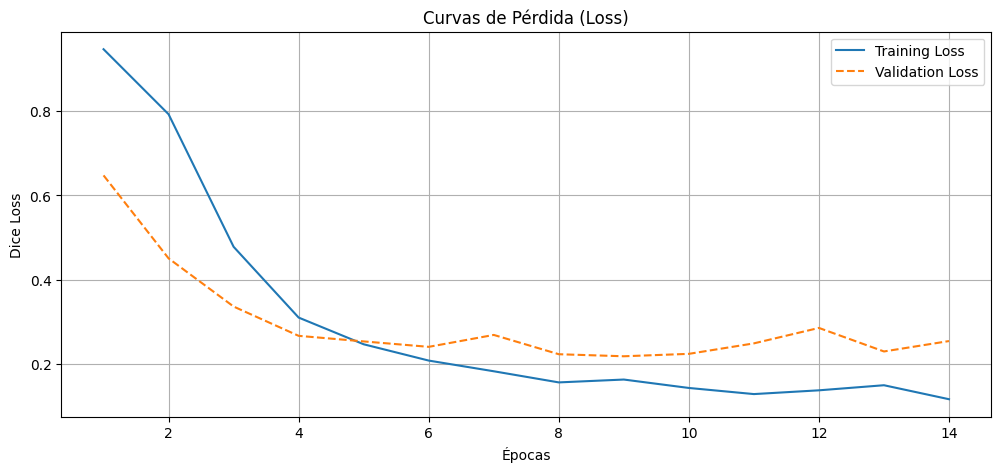

In [13]:
# Se grafican las curvas de pérdida de entrenamiento y validación para analizar el aprendizaje.
plt.figure(figsize=(12, 5))

plt.plot(range(1, epoch+2), train_loss_history, label='Training Loss')
plt.plot(range(1, epoch+2), val_loss_history, label='Validation Loss', linestyle='--')
plt.xlabel('Épocas')
plt.ylabel('Dice Loss')
plt.title('Curvas de Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Se prepara el conjunto de prueba para la evaluación final.
test_dataset = AneurysmDataset(df_test, NPY_FOLDER)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Batch 1 para evaluar una por una

model.eval() # Modo evaluación
test_dice_score = 0

In [15]:
# Se calcula el Dice Score promedio en el conjunto de prueba.
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
    
    # Se utiliza la relación: DiceScore = 1 - DiceLoss (aproximado por la función de pérdida).
        loss = criterion(outputs, masks)
        test_dice_score += (1 - loss.item())
        avg_test_dice = test_dice_score / len(test_loader)
print(f"Resultados Finales:")
print(f"Dice Score Promedio en Test: {avg_test_dice:.4f}")

Resultados Finales:
Dice Score Promedio en Test: 0.7947


In [16]:
def visualizar_predicciones_balanceadas(model, dataset, df_test, num_samples=3):
    """
    Muestra predicciones asegurando ver casos con aneurisma y casos sanos.
    """
    model.eval()
    
    # Se separan los índices de pacientes enfermos y sanos en el set de prueba.
    indices_enfermos = df_test[df_test['label'] == 1].index.tolist()
    indices_sanos = df_test[df_test['label'] == 0].index.tolist()
    
    # Se seleccionan muestras aleatorias de cada grupo.
    sel_enfermos = random.sample(indices_enfermos, min(num_samples, len(indices_enfermos)))
    sel_sanos = random.sample(indices_sanos, min(num_samples, len(indices_sanos)))
    
    indices_a_mostrar = sel_enfermos + sel_sanos
    random.shuffle(indices_a_mostrar) # Se mezclan para visualización variada.
    
    print(f"Mostrando {len(indices_a_mostrar)} ejemplos (Mezcla de sanos y enfermos)")
    
    for idx in indices_a_mostrar:
        # Se obtienen los datos del dataset.
        image_tensor, mask_tensor = dataset[idx]
        row_info = df_test.iloc[idx]
        
        # Se prepara el tensor de entrada.
        input_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Se realiza la predicción.
        with torch.no_grad():
            output = model(input_tensor)
            pred_prob = torch.sigmoid(output).cpu().numpy()[0, 0]
            
            # Aquí se decide si un píxel es aneurisma o no.
            # Se ha ajustado el umbral a 0.3 para aumentar la sensibilidad del modelo.
            pred_mask = pred_prob > 0.3
            
        # Se prepara la imagen para mostrar (solo el canal central verde).
        img_numpy = image_tensor.numpy()
        img_central = img_numpy[1, :, :] 
        
        true_mask = mask_tensor.numpy()[0]
        
        # Se generan los gráficos comparativos.
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        
        # 1. Imagen Central Original.
        ax[0].imshow(img_central, cmap='gray')
        tipo = "ENFERMO" if row_info['label'] == 1 else "SANO"
        ax[0].set_title(f"Paciente: {row_info['SeriesInstanceUID'][:8]}...\nTipo: {tipo}")
        ax[0].axis('off')
        
        # 2. Máscara Real (Ground Truth).
        ax[1].imshow(true_mask, cmap='gray')
        ax[1].set_title("Ground Truth (Real)")
        ax[1].axis('off')
        
        # 3. Mapa de Calor de Probabilidad.
        im3 = ax[2].imshow(pred_prob, cmap='jet', vmin=0, vmax=1)
        ax[2].set_title("Probabilidad IA")
        ax[2].axis('off')
        plt.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)
        
        # 4. Predicción Binaria Final.
        ax[3].imshow(pred_mask, cmap='gray')
        ax[3].set_title("Predicción Final (>0.3)")
        ax[3].axis('off')
        
        plt.tight_layout()
        plt.show()

Mostrando 6 ejemplos (Mezcla de sanos y enfermos)


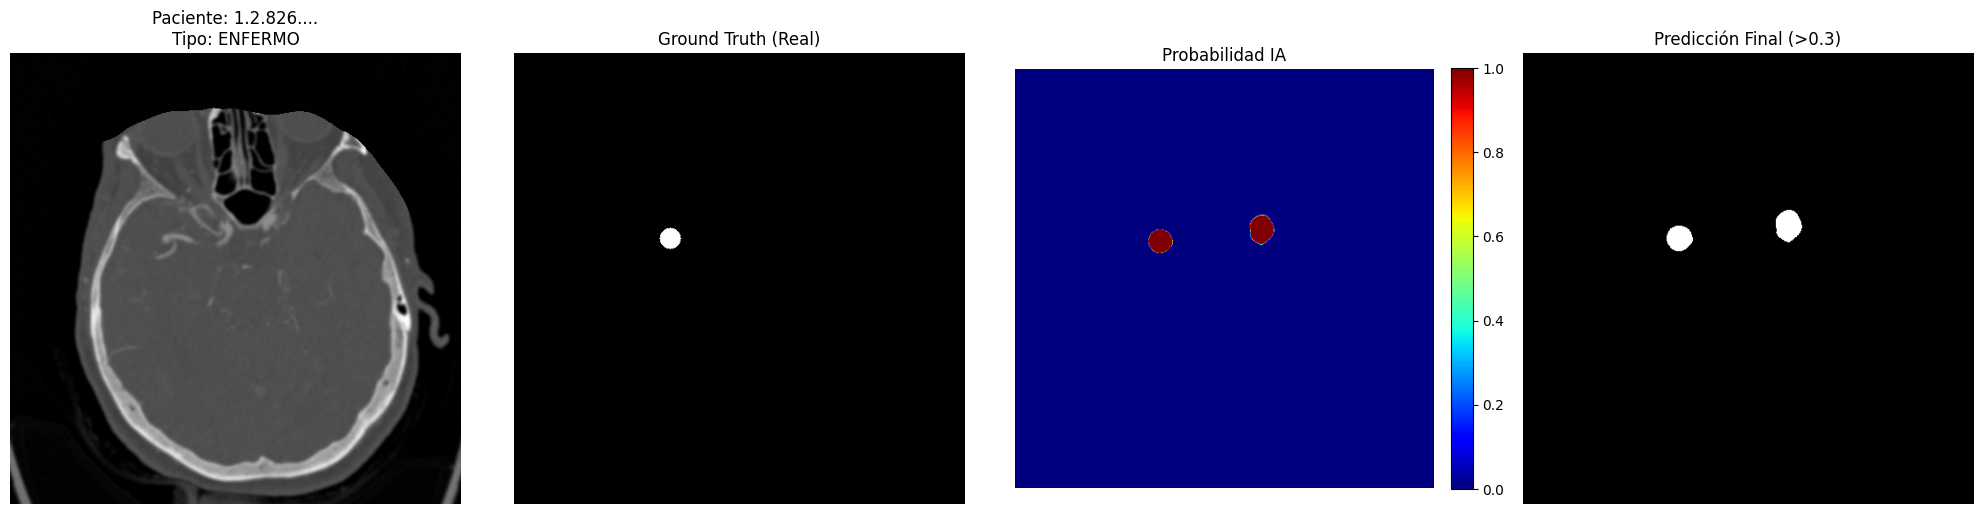

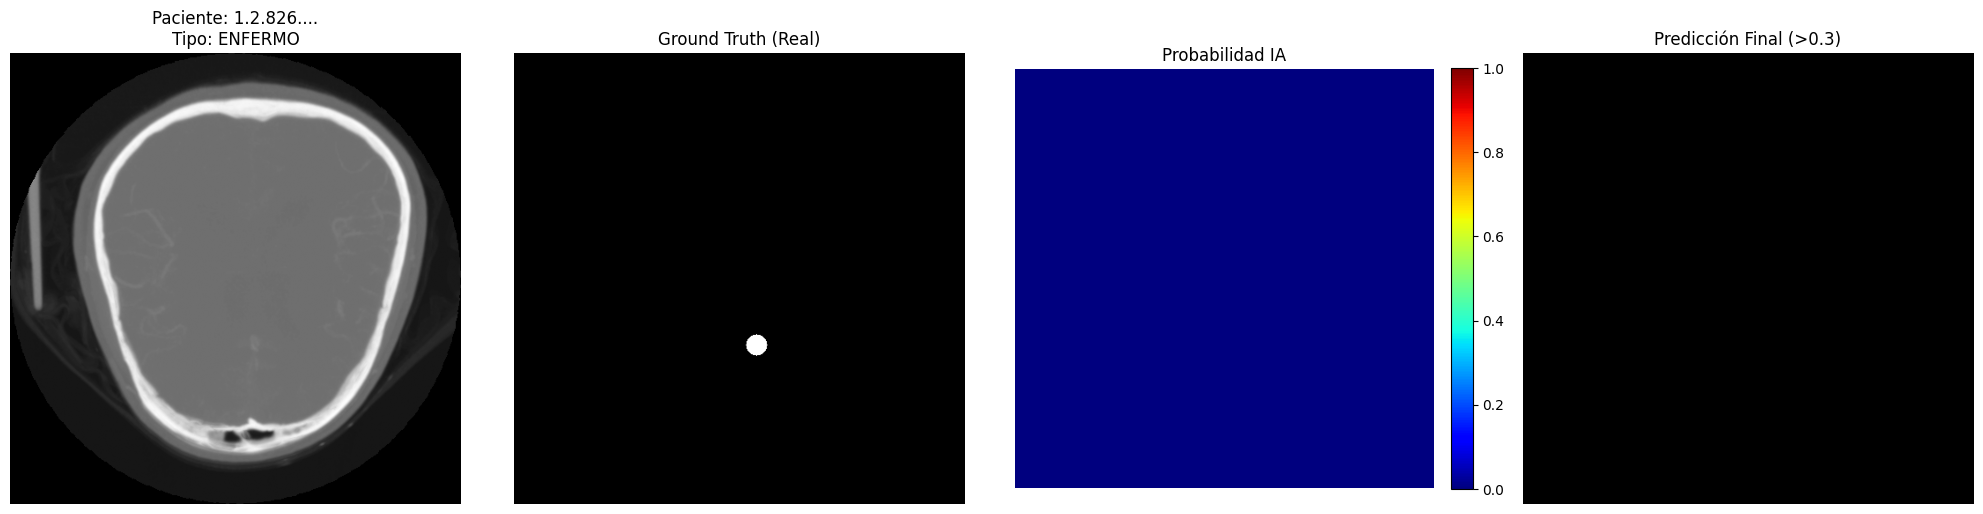

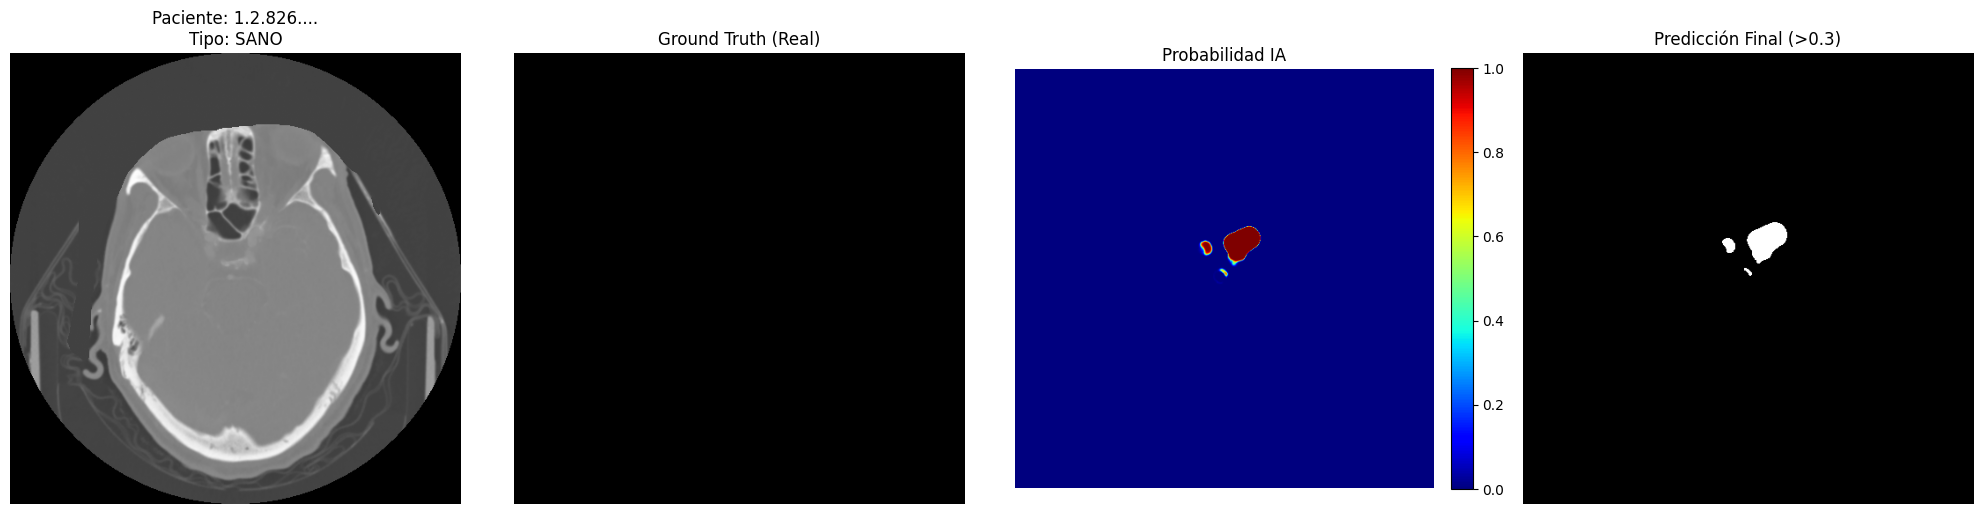

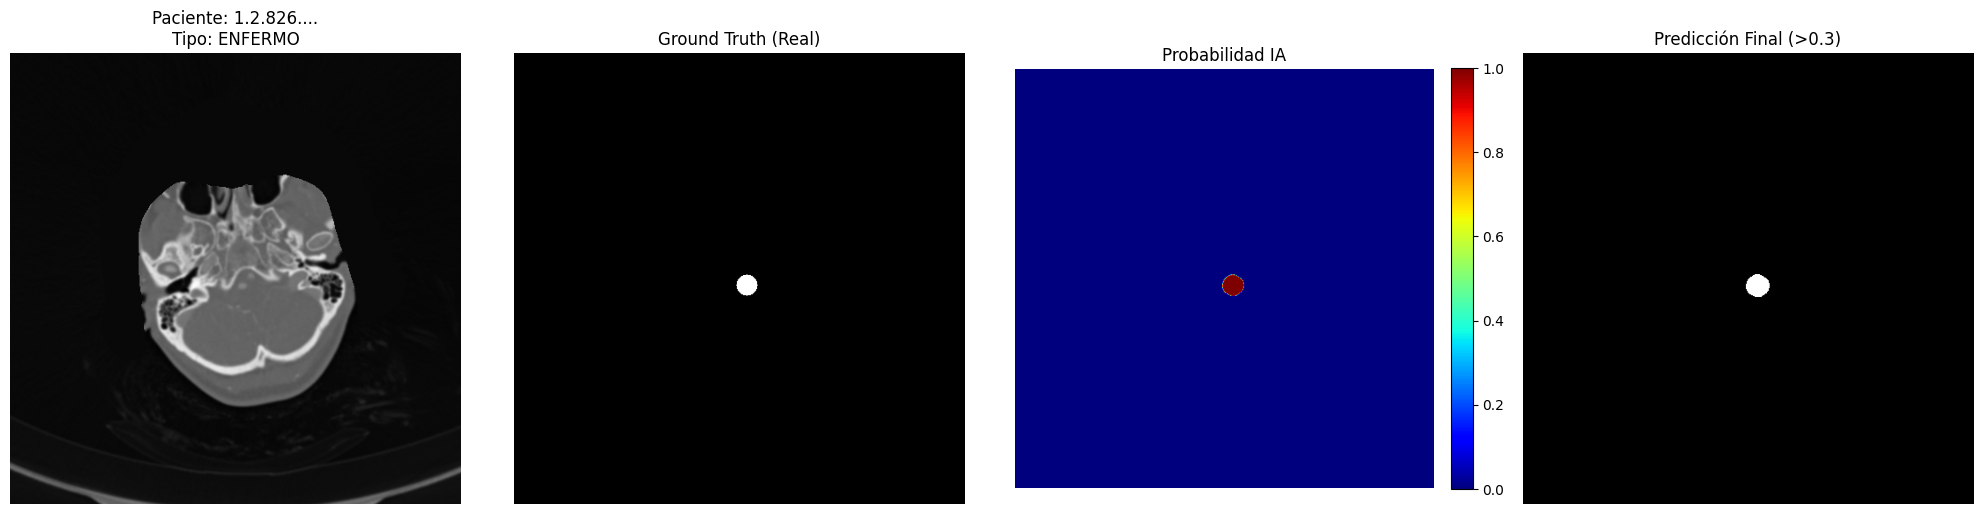

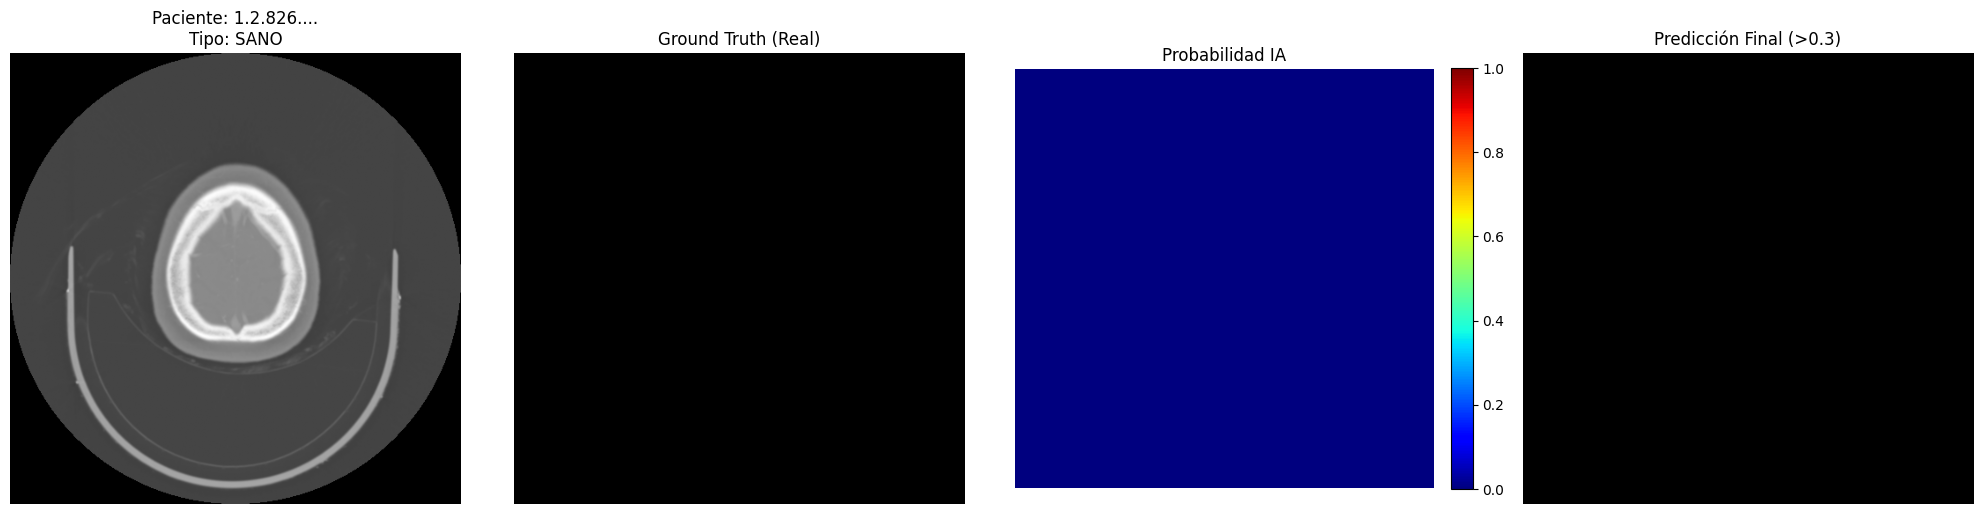

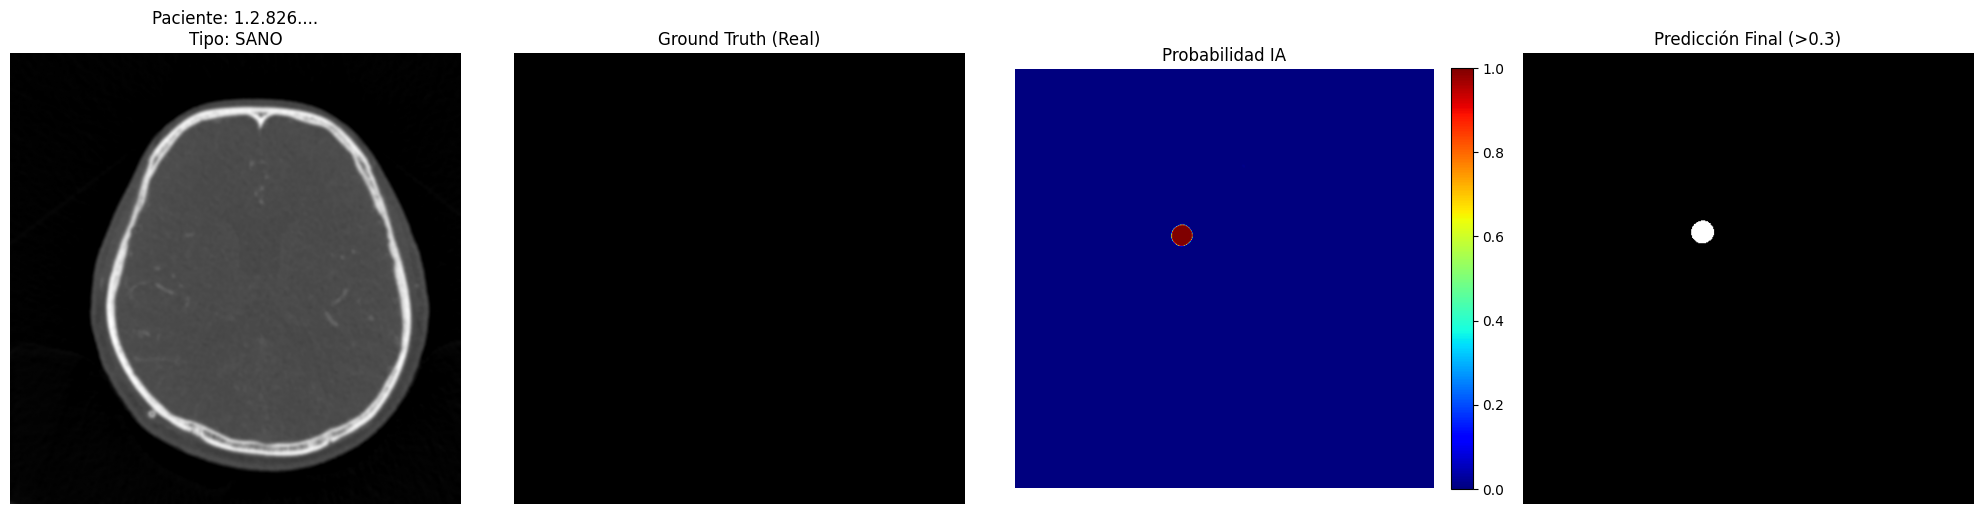

In [17]:
# Se ejecuta la función de visualización para inspeccionar cualitativamente los resultados.
if 'test_dataset' not in locals():
    test_dataset = AneurysmDataset(df_test, NPY_FOLDER)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Dataset de Test creado.")

visualizar_predicciones_balanceadas(model, test_dataset, df_test, num_samples=3)

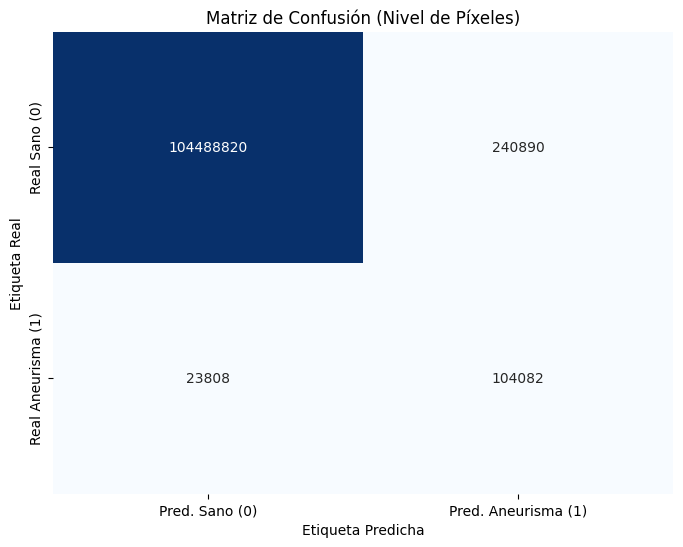

Métricas
Sensibilidad:  0.8138 (Capacidad de detectar aneurismas)
Especificidad: 0.9977 (Capacidad de descartar sanos)
Precisión:     0.3017
F1-Score:      0.4402


In [ ]:
import seaborn as sns

def graficar_matriz_confusion(model, loader, device):
    """
    Calcula y grafica la matriz de confusión a nivel de píxeles.
    """
    model.eval()
    
    # Contadores para la matriz de confusión.
    TP = 0 # Verdaderos Positivos
    TN = 0 # Verdaderos Negativos
    FP = 0 # Falsos Positivos
    FN = 0 # Falsos Negativos
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Se aplica el umbral de 0.3 para calcular las métricas finales, priorizando la detección.
            preds = (torch.sigmoid(outputs) > 0.3).float()
            
            # Se aplanan los tensores para comparar píxel a píxel.
            preds = preds.view(-1)
            masks = masks.view(-1)
            
            TP += ((preds == 1) & (masks == 1)).sum().item()
            TN += ((preds == 0) & (masks == 0)).sum().item()
            FP += ((preds == 1) & (masks == 0)).sum().item()
            FN += ((preds == 0) & (masks == 1)).sum().item()
            
    # Se construye la matriz.
    cm = np.array([[TN, FP], [FN, TP]])
    
    # Se calculan las métricas de rendimiento.
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 # Recall
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    # Se grafica la matriz de confusión.
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=['Pred. Sano (0)', 'Pred. Aneurisma (1)'],
                yticklabels=['Real Sano (0)', 'Real Aneurisma (1)'])
    
    plt.title('Matriz de Confusión (Nivel de Píxeles)')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()
    
    print(f"Métricas")
    print(f"Sensibilidad:  {sensitivity:.4f} (Capacidad de detectar aneurismas)")
    print(f"Especificidad: {specificity:.4f} (Capacidad de descartar sanos)")
    print(f"Precisión:     {precision:.4f}")
    print(f"F1-Score:      {f1_score:.4f}")

# Se ejecuta la función de matriz de confusión.
graficar_matriz_confusion(model, test_loader, device)

Este modelo alcanzó una sensibilidad de 0.8138, lo que representa una mejora notable en la capacidad de detectar los píxeles asociados a aneurismas, logrando identificar más del 81 \% de las regiones patológicas presentes en las imágenes.

La especificidad se mantuvo en un valor muy alto (0.9977), lo que indica que el modelo continúa clasificando correctamente la gran mayoría de los píxeles sanos, con una baja tasa de falsos positivos. Sin embargo, la precisión obtenida (0.3017) muestra que una parte considerable de las detecciones positivas no corresponde realmente a aneurismas.

Finalmente, el F1-score de 0.4402 refleja el equilibrio entre sensibilidad y precisión, lo que significa que el modelo está orientado a priorizar la detección de aneurismas.

Generando Curva Precision-Recall


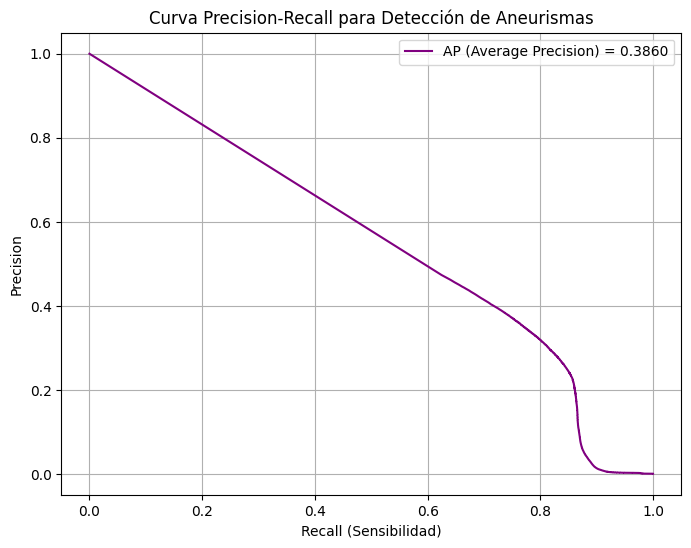

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def graficar_curva_pr(model, loader, device):
    """
    Calcula y grafica la curva Precision-Recall.
    Ideal para datasets desbalanceados como este (pocos píxeles de aneurisma vs muchos de fondo).
    """
    model.eval()
    y_true = []
    y_scores = []
    
    print("Generando Curva Precision-Recall")
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            prob_map = torch.sigmoid(outputs)
            
            # Se aplanan los resultados y se mueven a CPU para procesamiento con sklearn.
            y_true.extend(masks.view(-1).cpu().numpy())
            y_scores.extend(prob_map.view(-1).cpu().numpy())
            
    # Se calculan los valores de precisión y recall para diferentes umbrales.
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    
    # Se grafica la curva.
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP (Average Precision) = {ap:.4f}', color='purple')
    plt.xlabel('Recall (Sensibilidad)')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall para Detección de Aneurismas')
    plt.legend()
    plt.grid(True)
    plt.show()

# Se ejecuta el análisis de la curva Precision-Recall.
graficar_curva_pr(model, test_loader, device)

En este caso, se observa que la precisión es, en general, mayor que en el modelo anterior, lo que sugiere que las detecciones de aneurismas realizadas por el modelo son más confiables. Esta mejora se refleja en el incremento del valor de Average Precision (AP = 0.3860), el cual resume el desempeño global del modelo a lo largo de distintos umbrales de decisión. Como es habitual en problemas altamente desbalanceados, la precisión disminuye a medida que aumenta el recall; sin embargo, esta caída ocurre de forma más gradual, lo que indica un mejor compromiso entre la capacidad de detectar aneurismas y el control de falsos positivos.

## Referencias
[1] Olaf Ronneberger, Philipp Fischer y Thomas Brox. U-Net: Convolutional Networks for Bio- medical Image Segmentation. 2015. arXiv: 1505. 04597 [cs.CV]. url: https://arxiv.org/abs/ 1505.04597.

[2] Seyed Sadegh Mohseni Salehi, Deniz Erdogmus y Ali Gholipour. Tversky loss function for image segmentation using 3D fully convolutional deep networks. 2017. arXiv: 1706 . 05721 [cs.CV]. url: https://arxiv.org/abs/1706.05721.